In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from patch_gnn.data import load_ghesquire
import pandas as pd
from pyprojroot import here
import pickle as pkl
from patch_gnn.splitting import train_test_split
from jax import random
from patch_gnn.seqops import one_hot
from patch_gnn.unirep import unirep_reps
from patch_gnn.graph import graph_tensors
from patch_gnn.models import MPNN, DeepMPNN, DeepGAT
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score as evs
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error as mse
import pickle as pkl
from patch_gnn.graph import met_position
import seaborn as sns
from patch_gnn.tune import evotune_mpnn_class, evotune_rf

In [30]:
from jax.config import config
config.update("jax_debug_nans", True)

## Load data and its asscociated graphs
##### Data is the raw data, while its associated graph,pkl has only sasa and fluc features. Loading its associated garph is necessary given graphs.pkl contains accession-sequence identifier needed to subset raw data for analysis 

In [31]:
data = load_ghesquire()

#graph_pickle_path = here() / "data/ghesquire_2011/graphs.pkl"
processed_data_path = here() / "data/ghesquire_2011/processed_data.pkl"


# the cleaned data has everything processed and ready to be used for deep learning
with open(processed_data_path, "rb") as f:
    processed_data = pkl.load(f)
    
key = random.PRNGKey(490)

##### peptide length distribution

Text(0.5, 1.0, 'Peptide length distribution')

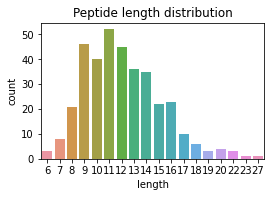

In [32]:
list(set(processed_data.sequence.str.len().tolist()))
f = plt.figure(figsize=(4,2.5))
ax = f.add_subplot(1,1,1)
length_dist = pd.DataFrame({'length': processed_data.sequence.str.len().value_counts().index,
                            'count': processed_data.sequence.str.len().value_counts()}).sort_values('length')
sns.barplot(data = length_dist, x = 'length', y = 'count')
ax.set_title("Peptide length distribution")

##### Split data in to train and test

In [33]:
train_df, test_df = train_test_split(key, processed_data) # 70% training, 30% testing
(train_df.shape), (test_df.shape) #359 total raw data points

((251, 18), (108, 18))

Note that this the num of train + test samples  = total graphs

In [34]:
def plot_y_eq_x(ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    minval = min(xmin, ymin)
    maxval = max(xmax, ymax)

    ax.plot([minval, maxval], [minval, maxval])

def plot_performance(
    model,
    trainX, trainY, testX, testY,
    model_name: str,
    ev_func1,
    ev_func2,
    checkpoint: int = None,
):
    fig, ax = plt.subplots(
        figsize=(10, 5), nrows=1, ncols=2, sharex=True, sharey=True,
    )
    # evaluate model is MPNN class, b/c other deep learning models inhert from this class, they are all under this class
    if isinstance(model, MPNN):
        train_preds = model.predict(trainX, checkpoint=checkpoint)
    else:
        train_preds = model.predict(trainX)
    ax[0].scatter(trainY, train_preds.squeeze())
    ax[0].set_title(f"Model: {model_name}, Train evs: {ev_func1(trainY, train_preds.squeeze()):.3f},mse: {ev_func2(trainY, train_preds.squeeze()):.3f}")
    plot_y_eq_x(ax[0])

    if isinstance(model, MPNN):
        test_preds = model.predict(testX, checkpoint=checkpoint)
    else:
        test_preds = model.predict(testX)
    ax[1].scatter(testY, test_preds.squeeze())
    ax[1].set_title(f"Model: {model_name}, Test evs: {ev_func1(testY, test_preds.squeeze()):.3f}, mse: {ev_func2(testY, test_preds.squeeze()):.3f}")
    plot_y_eq_x(ax[1])

## Deep learning related model of interests
- Sequence based models
    - One hot encoding with random forest
    - Unirep representation with random forest
- Sequence properties based models
    - Using SASA features to fit a linear model for Met oxi prediction
    - Using fluc features (AMN and NMA) to fit a linear model for Met oxi prediction, see `fluc_clinear_regression.ipynb`

##### According to the distribution graph above, pad it to length 30 is enough

In [35]:
train_oh = one_hot(train_df, 27) #pad sequence to 27 length and one hot encode it
test_oh = one_hot(test_df, 27)
print(train_oh.shape, test_oh.shape)

train_unirep = unirep_reps(train_df) # unirep representation of the sequence
test_unirep = unirep_reps(test_df)
print(train_unirep.shape, test_unirep.shape)



(251, 567) (108, 567)
(251, 1900) (108, 1900)


In [36]:
#load target value
train_target = train_df['ox_fwd_logit'].values
test_target = test_df['ox_fwd_logit'].values

## Linear model of interests
- Use SASA to predict oxidation
- Use ANM to predict oxidation
- use NMA to predict oxidation

In [37]:
with open(here() / "data/ghesquire_2011/sasa.pkl", "rb") as f:
    sasa_dfs = pkl.load(f)
with open(here() / "data/ghesquire_2011/ANM.pkl", "rb") as f:
    anm_dfs = pkl.load(f)
with open(here() / "data/ghesquire_2011/NMA.pkl", "rb") as f:
    nma_dfs = pkl.load(f)

In [38]:
from sklearn.linear_model import LinearRegression
def linear_model_data_forsasa(df, sasa_dfs):
    linear = []
    for acc, pos in zip(df["accession"], df["met_position"]):
        feats = sasa_dfs[acc].query("ResidNr == @pos")[["SASA/A^2", "N(overl)"]] #using only two features from sasa_dfs, want to compare with older models
        linear.append(feats)

    return pd.concat(linear)

def linear_model_data_for_anm_nma(df, feature_dfs):
    """
    return a feature vector 
    :params df: either train_df or test_df
    :params feature_df: either anm_dfs or nma_dfs, they are dictionaries
                        with key being accesssion and values being features associated
                        that accession number
    """
    linear = []
    for acc, pos in zip(df["accession"], df["met_position"]):
        # preprocessing already removed all the inf and nan values, so in theory there shouldn't be any
        if feature_dfs[acc].loc[:,'fluc'].isnull().any().sum()!=0:
            feature_dfs[acc] = feature_dfs[acc].replace(np.inf, 100000000, inplace =True)
        feats = feature_dfs[acc].query("resnos == @pos")[["fluc"]]
        linear.append(feats)
    return pd.concat(linear)


In [39]:
linear_models = {
    "sasa": linear_model_data_forsasa(train_df, sasa_dfs), 
    "anm": linear_model_data_for_anm_nma(train_df, anm_dfs),
    "nma": linear_model_data_for_anm_nma(train_df, nma_dfs),
    "sasa_test": linear_model_data_forsasa(test_df, sasa_dfs), 
    "anm_test": linear_model_data_for_anm_nma(test_df, anm_dfs),
    "nma_test": linear_model_data_for_anm_nma(test_df, nma_dfs)
}

In [40]:
sasa_linear = LinearRegression().fit(linear_models['sasa'], train_target)
anm_linear = LinearRegression().fit(linear_models['anm'], train_target)
nma_linear = LinearRegression().fit(linear_models['nma'], train_target)

In [41]:
#train_linear = linear_model_data(train_df, sasa_dfs)
#test_linear = linear_model_data(test_df, sasa_dfs)

In [42]:
#from sklearn.linear_model import LinearRegression
#model_linear = LinearRegression()
#model_linear.fit(train_linear, train_target)

### Define training for non-linear models

In [43]:
rf_max_depth_kwargs = {"name" : "max_depth", # this key value pair is required as is
                       "low" :2,  # one can change the value
                       "high" : 65, # one can change the value
                       "log" :True  #this key value pair is required as is
                        }
rf_n_estimator_kwargs = {"name" : "n_estimators",# this key value pair is required as is
                        "low" : 128, # one can change the value
                        "high" : 900, # one can change the value
                        "log" : True # this key value pair is required as is
                            }

In [44]:
best_param_for_rf_oh = evotune_rf( train_oh, train_target, rf_max_depth_kwargs, rf_n_estimator_kwargs,n_trials = 200)

[I 2021-07-06 19:55:41,190] A new study created in memory with name: no-name-517036f5-bd46-4685-9813-9412a3b33326


The params that were optimized {'max_depth': 11, 'n_estimators': 163}


[I 2021-07-06 19:55:41,594] Trial 0 finished with value: 0.4523952875717223 and parameters: {'max_depth': 11, 'n_estimators': 163}. Best is trial 0 with value: 0.4523952875717223.


The params that were optimized {'max_depth': 9, 'n_estimators': 135}


[I 2021-07-06 19:55:41,970] Trial 1 finished with value: 0.5668668604712966 and parameters: {'max_depth': 9, 'n_estimators': 135}. Best is trial 0 with value: 0.4523952875717223.


The params that were optimized {'max_depth': 32, 'n_estimators': 614}


[I 2021-07-06 19:55:43,226] Trial 2 finished with value: 0.205742389178052 and parameters: {'max_depth': 32, 'n_estimators': 614}. Best is trial 2 with value: 0.205742389178052.


The params that were optimized {'max_depth': 48, 'n_estimators': 802}


[I 2021-07-06 19:55:45,126] Trial 3 finished with value: 0.20928555622296488 and parameters: {'max_depth': 48, 'n_estimators': 802}. Best is trial 2 with value: 0.205742389178052.


The params that were optimized {'max_depth': 21, 'n_estimators': 663}


[I 2021-07-06 19:55:46,603] Trial 4 finished with value: 0.23817685335118396 and parameters: {'max_depth': 21, 'n_estimators': 663}. Best is trial 2 with value: 0.205742389178052.


The params that were optimized {'max_depth': 3, 'n_estimators': 191}


[I 2021-07-06 19:55:47,096] Trial 5 finished with value: 1.0981061748273808 and parameters: {'max_depth': 3, 'n_estimators': 191}. Best is trial 2 with value: 0.205742389178052.


The params that were optimized {'max_depth': 13, 'n_estimators': 540}


[I 2021-07-06 19:55:48,223] Trial 6 finished with value: 0.37537044850504525 and parameters: {'max_depth': 13, 'n_estimators': 540}. Best is trial 2 with value: 0.205742389178052.


The params that were optimized {'max_depth': 2, 'n_estimators': 504}


[I 2021-07-06 19:55:49,253] Trial 7 finished with value: 1.2215258452239985 and parameters: {'max_depth': 2, 'n_estimators': 504}. Best is trial 2 with value: 0.205742389178052.


The params that were optimized {'max_depth': 17, 'n_estimators': 143}


[I 2021-07-06 19:55:49,637] Trial 8 finished with value: 0.2891766424976851 and parameters: {'max_depth': 17, 'n_estimators': 143}. Best is trial 2 with value: 0.205742389178052.


The params that were optimized {'max_depth': 3, 'n_estimators': 285}


[I 2021-07-06 19:55:50,236] Trial 9 finished with value: 1.0955530891906857 and parameters: {'max_depth': 3, 'n_estimators': 285}. Best is trial 2 with value: 0.205742389178052.


The params that were optimized {'max_depth': 64, 'n_estimators': 363}


[I 2021-07-06 19:55:51,073] Trial 10 finished with value: 0.212197465156779 and parameters: {'max_depth': 64, 'n_estimators': 363}. Best is trial 2 with value: 0.205742389178052.


The params that were optimized {'max_depth': 63, 'n_estimators': 686}


[I 2021-07-06 19:55:52,522] Trial 11 finished with value: 0.20455956402849598 and parameters: {'max_depth': 63, 'n_estimators': 686}. Best is trial 11 with value: 0.20455956402849598.


The params that were optimized {'max_depth': 34, 'n_estimators': 872}


[I 2021-07-06 19:55:54,309] Trial 12 finished with value: 0.20703760488019657 and parameters: {'max_depth': 34, 'n_estimators': 872}. Best is trial 11 with value: 0.20455956402849598.


The params that were optimized {'max_depth': 34, 'n_estimators': 409}


[I 2021-07-06 19:55:55,195] Trial 13 finished with value: 0.2164909607708337 and parameters: {'max_depth': 34, 'n_estimators': 409}. Best is trial 11 with value: 0.20455956402849598.


The params that were optimized {'max_depth': 64, 'n_estimators': 686}


[I 2021-07-06 19:55:56,619] Trial 14 finished with value: 0.20679623552781956 and parameters: {'max_depth': 64, 'n_estimators': 686}. Best is trial 11 with value: 0.20455956402849598.


The params that were optimized {'max_depth': 31, 'n_estimators': 278}


[I 2021-07-06 19:55:57,295] Trial 15 finished with value: 0.20444958328411247 and parameters: {'max_depth': 31, 'n_estimators': 278}. Best is trial 15 with value: 0.20444958328411247.


The params that were optimized {'max_depth': 8, 'n_estimators': 252}


[I 2021-07-06 19:55:57,907] Trial 16 finished with value: 0.6390615328565443 and parameters: {'max_depth': 8, 'n_estimators': 252}. Best is trial 15 with value: 0.20444958328411247.


The params that were optimized {'max_depth': 6, 'n_estimators': 227}


[I 2021-07-06 19:55:58,473] Trial 17 finished with value: 0.7784498477954167 and parameters: {'max_depth': 6, 'n_estimators': 227}. Best is trial 15 with value: 0.20444958328411247.


The params that were optimized {'max_depth': 22, 'n_estimators': 310}


[I 2021-07-06 19:55:59,203] Trial 18 finished with value: 0.2294410001572083 and parameters: {'max_depth': 22, 'n_estimators': 310}. Best is trial 15 with value: 0.20444958328411247.


The params that were optimized {'max_depth': 48, 'n_estimators': 432}


[I 2021-07-06 19:56:00,229] Trial 19 finished with value: 0.2095943871662908 and parameters: {'max_depth': 48, 'n_estimators': 432}. Best is trial 15 with value: 0.20444958328411247.


The params that were optimized {'max_depth': 50, 'n_estimators': 208}


[I 2021-07-06 19:56:00,771] Trial 20 finished with value: 0.21374726538699682 and parameters: {'max_depth': 50, 'n_estimators': 208}. Best is trial 15 with value: 0.20444958328411247.


The params that were optimized {'max_depth': 30, 'n_estimators': 609}


[I 2021-07-06 19:56:02,104] Trial 21 finished with value: 0.20672382388980384 and parameters: {'max_depth': 30, 'n_estimators': 609}. Best is trial 15 with value: 0.20444958328411247.


The params that were optimized {'max_depth': 30, 'n_estimators': 886}


[I 2021-07-06 19:56:03,889] Trial 22 finished with value: 0.21179594479110464 and parameters: {'max_depth': 30, 'n_estimators': 886}. Best is trial 15 with value: 0.20444958328411247.


The params that were optimized {'max_depth': 42, 'n_estimators': 480}


[I 2021-07-06 19:56:04,965] Trial 23 finished with value: 0.20726458981331672 and parameters: {'max_depth': 42, 'n_estimators': 480}. Best is trial 15 with value: 0.20444958328411247.


The params that were optimized {'max_depth': 21, 'n_estimators': 365}


[I 2021-07-06 19:56:05,816] Trial 24 finished with value: 0.23891991194382195 and parameters: {'max_depth': 21, 'n_estimators': 365}. Best is trial 15 with value: 0.20444958328411247.


The params that were optimized {'max_depth': 65, 'n_estimators': 739}


[I 2021-07-06 19:56:07,401] Trial 25 finished with value: 0.20814061279129234 and parameters: {'max_depth': 65, 'n_estimators': 739}. Best is trial 15 with value: 0.20444958328411247.


The params that were optimized {'max_depth': 14, 'n_estimators': 577}


[I 2021-07-06 19:56:08,642] Trial 26 finished with value: 0.34208933689949456 and parameters: {'max_depth': 14, 'n_estimators': 577}. Best is trial 15 with value: 0.20444958328411247.


The params that were optimized {'max_depth': 26, 'n_estimators': 293}


[I 2021-07-06 19:56:09,359] Trial 27 finished with value: 0.21354985670273285 and parameters: {'max_depth': 26, 'n_estimators': 293}. Best is trial 15 with value: 0.20444958328411247.


The params that were optimized {'max_depth': 40, 'n_estimators': 440}


[I 2021-07-06 19:56:10,350] Trial 28 finished with value: 0.20383963501841718 and parameters: {'max_depth': 40, 'n_estimators': 440}. Best is trial 28 with value: 0.20383963501841718.


The params that were optimized {'max_depth': 47, 'n_estimators': 435}


[I 2021-07-06 19:56:11,280] Trial 29 finished with value: 0.2098162245007256 and parameters: {'max_depth': 47, 'n_estimators': 435}. Best is trial 28 with value: 0.20383963501841718.


The params that were optimized {'max_depth': 62, 'n_estimators': 249}


[I 2021-07-06 19:56:11,908] Trial 30 finished with value: 0.20961722045064757 and parameters: {'max_depth': 62, 'n_estimators': 249}. Best is trial 28 with value: 0.20383963501841718.


The params that were optimized {'max_depth': 35, 'n_estimators': 665}


[I 2021-07-06 19:56:13,281] Trial 31 finished with value: 0.2041248236426478 and parameters: {'max_depth': 35, 'n_estimators': 665}. Best is trial 28 with value: 0.20383963501841718.


The params that were optimized {'max_depth': 39, 'n_estimators': 334}


[I 2021-07-06 19:56:14,073] Trial 32 finished with value: 0.20443873865615902 and parameters: {'max_depth': 39, 'n_estimators': 334}. Best is trial 28 with value: 0.20383963501841718.


The params that were optimized {'max_depth': 39, 'n_estimators': 343}


[I 2021-07-06 19:56:14,882] Trial 33 finished with value: 0.20355900230345533 and parameters: {'max_depth': 39, 'n_estimators': 343}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 41, 'n_estimators': 337}


[I 2021-07-06 19:56:15,622] Trial 34 finished with value: 0.2106250583774569 and parameters: {'max_depth': 41, 'n_estimators': 337}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 38, 'n_estimators': 392}


[I 2021-07-06 19:56:16,514] Trial 35 finished with value: 0.20958692787288338 and parameters: {'max_depth': 38, 'n_estimators': 392}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 24, 'n_estimators': 336}


[I 2021-07-06 19:56:17,268] Trial 36 finished with value: 0.22914980307396915 and parameters: {'max_depth': 24, 'n_estimators': 336}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 18, 'n_estimators': 473}


[I 2021-07-06 19:56:18,250] Trial 37 finished with value: 0.2661915070591688 and parameters: {'max_depth': 18, 'n_estimators': 473}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 52, 'n_estimators': 526}


[I 2021-07-06 19:56:19,403] Trial 38 finished with value: 0.20579059160875776 and parameters: {'max_depth': 52, 'n_estimators': 526}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 10, 'n_estimators': 374}


[I 2021-07-06 19:56:20,219] Trial 39 finished with value: 0.5039958020851992 and parameters: {'max_depth': 10, 'n_estimators': 374}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 17, 'n_estimators': 328}


[I 2021-07-06 19:56:20,980] Trial 40 finished with value: 0.2827209893646164 and parameters: {'max_depth': 17, 'n_estimators': 328}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 27, 'n_estimators': 266}


[I 2021-07-06 19:56:21,642] Trial 41 finished with value: 0.2124742741479209 and parameters: {'max_depth': 27, 'n_estimators': 266}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 37, 'n_estimators': 184}


[I 2021-07-06 19:56:22,077] Trial 42 finished with value: 0.2179472620711497 and parameters: {'max_depth': 37, 'n_estimators': 184}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 55, 'n_estimators': 291}


[I 2021-07-06 19:56:22,716] Trial 43 finished with value: 0.21406265471681715 and parameters: {'max_depth': 55, 'n_estimators': 291}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 43, 'n_estimators': 222}


[I 2021-07-06 19:56:23,278] Trial 44 finished with value: 0.21133078481401338 and parameters: {'max_depth': 43, 'n_estimators': 222}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 30, 'n_estimators': 266}


[I 2021-07-06 19:56:23,919] Trial 45 finished with value: 0.20420378571613995 and parameters: {'max_depth': 30, 'n_estimators': 266}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 27, 'n_estimators': 311}


[I 2021-07-06 19:56:24,652] Trial 46 finished with value: 0.21187039334199048 and parameters: {'max_depth': 27, 'n_estimators': 311}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 35, 'n_estimators': 409}


[I 2021-07-06 19:56:25,569] Trial 47 finished with value: 0.2144041920807532 and parameters: {'max_depth': 35, 'n_estimators': 409}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 56, 'n_estimators': 768}


[I 2021-07-06 19:56:27,177] Trial 48 finished with value: 0.20720363759263208 and parameters: {'max_depth': 56, 'n_estimators': 768}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 20, 'n_estimators': 453}


[I 2021-07-06 19:56:28,199] Trial 49 finished with value: 0.24701275968832398 and parameters: {'max_depth': 20, 'n_estimators': 453}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 12, 'n_estimators': 560}


[I 2021-07-06 19:56:29,435] Trial 50 finished with value: 0.41081444855540045 and parameters: {'max_depth': 12, 'n_estimators': 560}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 31, 'n_estimators': 264}


[I 2021-07-06 19:56:30,093] Trial 51 finished with value: 0.2144805693489647 and parameters: {'max_depth': 31, 'n_estimators': 264}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 42, 'n_estimators': 231}


[I 2021-07-06 19:56:30,634] Trial 52 finished with value: 0.2097700860470298 and parameters: {'max_depth': 42, 'n_estimators': 231}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 33, 'n_estimators': 273}


[I 2021-07-06 19:56:31,295] Trial 53 finished with value: 0.20886252927535523 and parameters: {'max_depth': 33, 'n_estimators': 273}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 24, 'n_estimators': 311}


[I 2021-07-06 19:56:32,066] Trial 54 finished with value: 0.22383736770384707 and parameters: {'max_depth': 24, 'n_estimators': 311}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 15, 'n_estimators': 350}


[I 2021-07-06 19:56:32,864] Trial 55 finished with value: 0.32032525577833965 and parameters: {'max_depth': 15, 'n_estimators': 350}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 6, 'n_estimators': 246}


[I 2021-07-06 19:56:33,487] Trial 56 finished with value: 0.7858596249992963 and parameters: {'max_depth': 6, 'n_estimators': 246}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 30, 'n_estimators': 200}


[I 2021-07-06 19:56:34,046] Trial 57 finished with value: 0.2098834192970082 and parameters: {'max_depth': 30, 'n_estimators': 200}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 38, 'n_estimators': 390}


[I 2021-07-06 19:56:34,923] Trial 58 finished with value: 0.20749612241213217 and parameters: {'max_depth': 38, 'n_estimators': 390}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 47, 'n_estimators': 168}


[I 2021-07-06 19:56:35,366] Trial 59 finished with value: 0.2093580957801877 and parameters: {'max_depth': 47, 'n_estimators': 168}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 25, 'n_estimators': 648}


[I 2021-07-06 19:56:36,689] Trial 60 finished with value: 0.21449137010383693 and parameters: {'max_depth': 25, 'n_estimators': 648}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 63, 'n_estimators': 831}


[I 2021-07-06 19:56:38,367] Trial 61 finished with value: 0.20675674932566893 and parameters: {'max_depth': 63, 'n_estimators': 831}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 57, 'n_estimators': 736}


[I 2021-07-06 19:56:39,912] Trial 62 finished with value: 0.204000513748242 and parameters: {'max_depth': 57, 'n_estimators': 736}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 54, 'n_estimators': 616}


[I 2021-07-06 19:56:41,246] Trial 63 finished with value: 0.20795657067071283 and parameters: {'max_depth': 54, 'n_estimators': 616}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 46, 'n_estimators': 690}


[I 2021-07-06 19:56:42,726] Trial 64 finished with value: 0.21056075154383413 and parameters: {'max_depth': 46, 'n_estimators': 690}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 36, 'n_estimators': 288}


[I 2021-07-06 19:56:43,698] Trial 65 finished with value: 0.20659122093026056 and parameters: {'max_depth': 36, 'n_estimators': 288}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 29, 'n_estimators': 739}


[I 2021-07-06 19:56:45,256] Trial 66 finished with value: 0.20929435418413703 and parameters: {'max_depth': 29, 'n_estimators': 739}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 40, 'n_estimators': 319}


[I 2021-07-06 19:56:46,022] Trial 67 finished with value: 0.20957547469944005 and parameters: {'max_depth': 40, 'n_estimators': 319}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 58, 'n_estimators': 500}


[I 2021-07-06 19:56:47,148] Trial 68 finished with value: 0.2055065931728111 and parameters: {'max_depth': 58, 'n_estimators': 500}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 34, 'n_estimators': 239}


[I 2021-07-06 19:56:47,705] Trial 69 finished with value: 0.20737649238645162 and parameters: {'max_depth': 34, 'n_estimators': 239}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 22, 'n_estimators': 354}


[I 2021-07-06 19:56:48,511] Trial 70 finished with value: 0.22836402961714594 and parameters: {'max_depth': 22, 'n_estimators': 354}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 50, 'n_estimators': 824}


[I 2021-07-06 19:56:50,225] Trial 71 finished with value: 0.2056115125909905 and parameters: {'max_depth': 50, 'n_estimators': 824}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 45, 'n_estimators': 696}


[I 2021-07-06 19:56:51,639] Trial 72 finished with value: 0.2061254219994278 and parameters: {'max_depth': 45, 'n_estimators': 696}. Best is trial 33 with value: 0.20355900230345533.


The params that were optimized {'max_depth': 58, 'n_estimators': 599}


[I 2021-07-06 19:56:52,871] Trial 73 finished with value: 0.2035494391848195 and parameters: {'max_depth': 58, 'n_estimators': 599}. Best is trial 73 with value: 0.2035494391848195.


The params that were optimized {'max_depth': 2, 'n_estimators': 601}


[I 2021-07-06 19:56:54,073] Trial 74 finished with value: 1.220432097737356 and parameters: {'max_depth': 2, 'n_estimators': 601}. Best is trial 73 with value: 0.2035494391848195.


The params that were optimized {'max_depth': 65, 'n_estimators': 537}


[I 2021-07-06 19:56:55,248] Trial 75 finished with value: 0.21003026232459293 and parameters: {'max_depth': 65, 'n_estimators': 537}. Best is trial 73 with value: 0.2035494391848195.


The params that were optimized {'max_depth': 39, 'n_estimators': 657}


[I 2021-07-06 19:56:56,659] Trial 76 finished with value: 0.207406731164926 and parameters: {'max_depth': 39, 'n_estimators': 657}. Best is trial 73 with value: 0.2035494391848195.


The params that were optimized {'max_depth': 32, 'n_estimators': 302}


[I 2021-07-06 19:56:57,400] Trial 77 finished with value: 0.20803166750871147 and parameters: {'max_depth': 32, 'n_estimators': 302}. Best is trial 73 with value: 0.2035494391848195.


The params that were optimized {'max_depth': 60, 'n_estimators': 277}


[I 2021-07-06 19:56:58,048] Trial 78 finished with value: 0.21614893783918443 and parameters: {'max_depth': 60, 'n_estimators': 277}. Best is trial 73 with value: 0.2035494391848195.


The params that were optimized {'max_depth': 28, 'n_estimators': 414}


[I 2021-07-06 19:56:58,985] Trial 79 finished with value: 0.2141100009675348 and parameters: {'max_depth': 28, 'n_estimators': 414}. Best is trial 73 with value: 0.2035494391848195.


The params that were optimized {'max_depth': 51, 'n_estimators': 887}


[I 2021-07-06 19:57:00,820] Trial 80 finished with value: 0.20498982038680905 and parameters: {'max_depth': 51, 'n_estimators': 887}. Best is trial 73 with value: 0.2035494391848195.


The params that were optimized {'max_depth': 44, 'n_estimators': 769}


[I 2021-07-06 19:57:02,439] Trial 81 finished with value: 0.2081821854443231 and parameters: {'max_depth': 44, 'n_estimators': 769}. Best is trial 73 with value: 0.2035494391848195.


The params that were optimized {'max_depth': 55, 'n_estimators': 730}


[I 2021-07-06 19:57:03,999] Trial 82 finished with value: 0.2052889672921193 and parameters: {'max_depth': 55, 'n_estimators': 730}. Best is trial 73 with value: 0.2035494391848195.


The params that were optimized {'max_depth': 36, 'n_estimators': 257}


[I 2021-07-06 19:57:04,644] Trial 83 finished with value: 0.21226600136801593 and parameters: {'max_depth': 36, 'n_estimators': 257}. Best is trial 73 with value: 0.2035494391848195.


The params that were optimized {'max_depth': 42, 'n_estimators': 571}


[I 2021-07-06 19:57:05,857] Trial 84 finished with value: 0.20619694287745693 and parameters: {'max_depth': 42, 'n_estimators': 571}. Best is trial 73 with value: 0.2035494391848195.


The params that were optimized {'max_depth': 65, 'n_estimators': 637}


[I 2021-07-06 19:57:07,239] Trial 85 finished with value: 0.2103196409036662 and parameters: {'max_depth': 65, 'n_estimators': 637}. Best is trial 73 with value: 0.2035494391848195.


The params that were optimized {'max_depth': 50, 'n_estimators': 378}


[I 2021-07-06 19:57:08,124] Trial 86 finished with value: 0.2024901817291798 and parameters: {'max_depth': 50, 'n_estimators': 378}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 3, 'n_estimators': 376}


[I 2021-07-06 19:57:08,962] Trial 87 finished with value: 1.101302551267026 and parameters: {'max_depth': 3, 'n_estimators': 376}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 49, 'n_estimators': 449}


[I 2021-07-06 19:57:09,981] Trial 88 finished with value: 0.20941885657138845 and parameters: {'max_depth': 49, 'n_estimators': 449}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 39, 'n_estimators': 326}


[I 2021-07-06 19:57:10,766] Trial 89 finished with value: 0.20971691360904018 and parameters: {'max_depth': 39, 'n_estimators': 326}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 33, 'n_estimators': 351}


[I 2021-07-06 19:57:11,586] Trial 90 finished with value: 0.21197919171291316 and parameters: {'max_depth': 33, 'n_estimators': 351}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 60, 'n_estimators': 396}


[I 2021-07-06 19:57:12,449] Trial 91 finished with value: 0.20847309817577872 and parameters: {'max_depth': 60, 'n_estimators': 396}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 51, 'n_estimators': 711}


[I 2021-07-06 19:57:13,971] Trial 92 finished with value: 0.2094271152118278 and parameters: {'max_depth': 51, 'n_estimators': 711}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 45, 'n_estimators': 781}


[I 2021-07-06 19:57:15,649] Trial 93 finished with value: 0.20696142657063069 and parameters: {'max_depth': 45, 'n_estimators': 781}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 56, 'n_estimators': 376}


[I 2021-07-06 19:57:16,524] Trial 94 finished with value: 0.20910865551659047 and parameters: {'max_depth': 56, 'n_estimators': 376}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 36, 'n_estimators': 338}


[I 2021-07-06 19:57:17,328] Trial 95 finished with value: 0.20489743497719792 and parameters: {'max_depth': 36, 'n_estimators': 338}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 40, 'n_estimators': 297}


[I 2021-07-06 19:57:17,983] Trial 96 finished with value: 0.20334589504114334 and parameters: {'max_depth': 40, 'n_estimators': 297}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 31, 'n_estimators': 297}


[I 2021-07-06 19:57:18,670] Trial 97 finished with value: 0.21524705794732368 and parameters: {'max_depth': 31, 'n_estimators': 297}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 25, 'n_estimators': 216}


[I 2021-07-06 19:57:19,183] Trial 98 finished with value: 0.21438790610157307 and parameters: {'max_depth': 25, 'n_estimators': 216}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 42, 'n_estimators': 270}


[I 2021-07-06 19:57:19,826] Trial 99 finished with value: 0.20803360748730196 and parameters: {'max_depth': 42, 'n_estimators': 270}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 28, 'n_estimators': 318}


[I 2021-07-06 19:57:20,576] Trial 100 finished with value: 0.2113904362250783 and parameters: {'max_depth': 28, 'n_estimators': 318}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 48, 'n_estimators': 280}


[I 2021-07-06 19:57:21,242] Trial 101 finished with value: 0.2085198293879469 and parameters: {'max_depth': 48, 'n_estimators': 280}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 40, 'n_estimators': 665}


[I 2021-07-06 19:57:22,628] Trial 102 finished with value: 0.20679219686938935 and parameters: {'max_depth': 40, 'n_estimators': 665}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 8, 'n_estimators': 597}


[I 2021-07-06 19:57:23,829] Trial 103 finished with value: 0.6287172923127003 and parameters: {'max_depth': 8, 'n_estimators': 597}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 34, 'n_estimators': 303}


[I 2021-07-06 19:57:24,567] Trial 104 finished with value: 0.2078565161810164 and parameters: {'max_depth': 34, 'n_estimators': 303}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 54, 'n_estimators': 511}


[I 2021-07-06 19:57:25,709] Trial 105 finished with value: 0.20369079008108862 and parameters: {'max_depth': 54, 'n_estimators': 511}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 52, 'n_estimators': 480}


[I 2021-07-06 19:57:26,780] Trial 106 finished with value: 0.2100450377460141 and parameters: {'max_depth': 52, 'n_estimators': 480}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 19, 'n_estimators': 514}


[I 2021-07-06 19:57:27,895] Trial 107 finished with value: 0.253436439235444 and parameters: {'max_depth': 19, 'n_estimators': 514}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 2, 'n_estimators': 558}


[I 2021-07-06 19:57:29,036] Trial 108 finished with value: 1.2207034617291699 and parameters: {'max_depth': 2, 'n_estimators': 558}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 43, 'n_estimators': 426}


[I 2021-07-06 19:57:29,998] Trial 109 finished with value: 0.2070325782139884 and parameters: {'max_depth': 43, 'n_estimators': 426}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 37, 'n_estimators': 460}


[I 2021-07-06 19:57:31,026] Trial 110 finished with value: 0.21199280398639522 and parameters: {'max_depth': 37, 'n_estimators': 460}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 60, 'n_estimators': 622}


[I 2021-07-06 19:57:32,357] Trial 111 finished with value: 0.20547694086038534 and parameters: {'max_depth': 60, 'n_estimators': 622}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 45, 'n_estimators': 678}


[I 2021-07-06 19:57:33,821] Trial 112 finished with value: 0.20474452307770383 and parameters: {'max_depth': 45, 'n_estimators': 678}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 54, 'n_estimators': 502}


[I 2021-07-06 19:57:34,926] Trial 113 finished with value: 0.2069537094299262 and parameters: {'max_depth': 54, 'n_estimators': 502}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 48, 'n_estimators': 262}


[I 2021-07-06 19:57:35,902] Trial 114 finished with value: 0.21122901045212858 and parameters: {'max_depth': 48, 'n_estimators': 262}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 31, 'n_estimators': 241}


[I 2021-07-06 19:57:36,512] Trial 115 finished with value: 0.21446143990494793 and parameters: {'max_depth': 31, 'n_estimators': 241}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 39, 'n_estimators': 358}


[I 2021-07-06 19:57:37,316] Trial 116 finished with value: 0.2068999397986091 and parameters: {'max_depth': 39, 'n_estimators': 358}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 57, 'n_estimators': 588}


[I 2021-07-06 19:57:38,549] Trial 117 finished with value: 0.20648840579569644 and parameters: {'max_depth': 57, 'n_estimators': 588}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 65, 'n_estimators': 287}


[I 2021-07-06 19:57:39,275] Trial 118 finished with value: 0.21112782051120396 and parameters: {'max_depth': 65, 'n_estimators': 287}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 22, 'n_estimators': 542}


[I 2021-07-06 19:57:40,465] Trial 119 finished with value: 0.23582747558967945 and parameters: {'max_depth': 22, 'n_estimators': 542}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 35, 'n_estimators': 390}


[I 2021-07-06 19:57:41,308] Trial 120 finished with value: 0.20413350417943935 and parameters: {'max_depth': 35, 'n_estimators': 390}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 35, 'n_estimators': 401}


[I 2021-07-06 19:57:42,187] Trial 121 finished with value: 0.20798997528237947 and parameters: {'max_depth': 35, 'n_estimators': 401}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 42, 'n_estimators': 382}


[I 2021-07-06 19:57:43,021] Trial 122 finished with value: 0.2093926675809163 and parameters: {'max_depth': 42, 'n_estimators': 382}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 28, 'n_estimators': 416}


[I 2021-07-06 19:57:43,957] Trial 123 finished with value: 0.21091935818214097 and parameters: {'max_depth': 28, 'n_estimators': 416}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 33, 'n_estimators': 341}


[I 2021-07-06 19:57:44,758] Trial 124 finished with value: 0.20670061732173844 and parameters: {'max_depth': 33, 'n_estimators': 341}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 47, 'n_estimators': 324}


[I 2021-07-06 19:57:45,525] Trial 125 finished with value: 0.2055642549214627 and parameters: {'max_depth': 47, 'n_estimators': 324}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 52, 'n_estimators': 843}


[I 2021-07-06 19:57:47,278] Trial 126 finished with value: 0.20462547531798078 and parameters: {'max_depth': 52, 'n_estimators': 843}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 2, 'n_estimators': 437}


[I 2021-07-06 19:57:48,193] Trial 127 finished with value: 1.2195236154667124 and parameters: {'max_depth': 2, 'n_estimators': 437}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 30, 'n_estimators': 366}


[I 2021-07-06 19:57:49,040] Trial 128 finished with value: 0.2090428751169892 and parameters: {'max_depth': 30, 'n_estimators': 366}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 37, 'n_estimators': 751}


[I 2021-07-06 19:57:50,595] Trial 129 finished with value: 0.20967405200662678 and parameters: {'max_depth': 37, 'n_estimators': 751}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 40, 'n_estimators': 712}


[I 2021-07-06 19:57:52,102] Trial 130 finished with value: 0.20919543491267897 and parameters: {'max_depth': 40, 'n_estimators': 712}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 53, 'n_estimators': 814}


[I 2021-07-06 19:57:53,809] Trial 131 finished with value: 0.20967755751268466 and parameters: {'max_depth': 53, 'n_estimators': 814}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 61, 'n_estimators': 845}


[I 2021-07-06 19:57:55,512] Trial 132 finished with value: 0.20740944595919775 and parameters: {'max_depth': 61, 'n_estimators': 845}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 50, 'n_estimators': 789}


[I 2021-07-06 19:57:57,147] Trial 133 finished with value: 0.20706064156567505 and parameters: {'max_depth': 50, 'n_estimators': 789}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 46, 'n_estimators': 857}


[I 2021-07-06 19:57:58,893] Trial 134 finished with value: 0.2105828394297116 and parameters: {'max_depth': 46, 'n_estimators': 857}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 44, 'n_estimators': 640}


[I 2021-07-06 19:58:00,269] Trial 135 finished with value: 0.20438766431943342 and parameters: {'max_depth': 44, 'n_estimators': 640}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 42, 'n_estimators': 628}


[I 2021-07-06 19:58:01,624] Trial 136 finished with value: 0.20626122228836596 and parameters: {'max_depth': 42, 'n_estimators': 628}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 37, 'n_estimators': 308}


[I 2021-07-06 19:58:02,371] Trial 137 finished with value: 0.21167236420945762 and parameters: {'max_depth': 37, 'n_estimators': 308}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 6, 'n_estimators': 655}


[I 2021-07-06 19:58:03,724] Trial 138 finished with value: 0.786352835663958 and parameters: {'max_depth': 6, 'n_estimators': 655}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 32, 'n_estimators': 384}


[I 2021-07-06 19:58:04,562] Trial 139 finished with value: 0.20649636198056542 and parameters: {'max_depth': 32, 'n_estimators': 384}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 26, 'n_estimators': 341}


[I 2021-07-06 19:58:05,303] Trial 140 finished with value: 0.21487722743970775 and parameters: {'max_depth': 26, 'n_estimators': 341}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 56, 'n_estimators': 700}


[I 2021-07-06 19:58:06,718] Trial 141 finished with value: 0.2060644359803911 and parameters: {'max_depth': 56, 'n_estimators': 700}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 44, 'n_estimators': 475}


[I 2021-07-06 19:58:07,783] Trial 142 finished with value: 0.20799695098320725 and parameters: {'max_depth': 44, 'n_estimators': 475}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 50, 'n_estimators': 250}


[I 2021-07-06 19:58:08,409] Trial 143 finished with value: 0.20754026358931454 and parameters: {'max_depth': 50, 'n_estimators': 250}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 65, 'n_estimators': 602}


[I 2021-07-06 19:58:09,698] Trial 144 finished with value: 0.20904499060910847 and parameters: {'max_depth': 65, 'n_estimators': 602}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 34, 'n_estimators': 732}


[I 2021-07-06 19:58:11,256] Trial 145 finished with value: 0.20564063352619338 and parameters: {'max_depth': 34, 'n_estimators': 732}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 2, 'n_estimators': 676}


[I 2021-07-06 19:58:12,556] Trial 146 finished with value: 1.220205969550475 and parameters: {'max_depth': 2, 'n_estimators': 676}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 39, 'n_estimators': 646}


[I 2021-07-06 19:58:13,979] Trial 147 finished with value: 0.20787879807370377 and parameters: {'max_depth': 39, 'n_estimators': 646}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 59, 'n_estimators': 570}


[I 2021-07-06 19:58:15,147] Trial 148 finished with value: 0.20444040866579613 and parameters: {'max_depth': 59, 'n_estimators': 570}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 59, 'n_estimators': 545}


[I 2021-07-06 19:58:16,329] Trial 149 finished with value: 0.20511394293515342 and parameters: {'max_depth': 59, 'n_estimators': 545}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 46, 'n_estimators': 577}


[I 2021-07-06 19:58:17,568] Trial 150 finished with value: 0.2075711515111531 and parameters: {'max_depth': 46, 'n_estimators': 577}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 54, 'n_estimators': 518}


[I 2021-07-06 19:58:18,661] Trial 151 finished with value: 0.20800667265984046 and parameters: {'max_depth': 54, 'n_estimators': 518}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 50, 'n_estimators': 633}


[I 2021-07-06 19:58:19,978] Trial 152 finished with value: 0.20577488033543678 and parameters: {'max_depth': 50, 'n_estimators': 633}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 65, 'n_estimators': 555}


[I 2021-07-06 19:58:21,134] Trial 153 finished with value: 0.20925539895598363 and parameters: {'max_depth': 65, 'n_estimators': 555}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 58, 'n_estimators': 363}


[I 2021-07-06 19:58:22,008] Trial 154 finished with value: 0.2086390161476079 and parameters: {'max_depth': 58, 'n_estimators': 363}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 41, 'n_estimators': 611}


[I 2021-07-06 19:58:23,331] Trial 155 finished with value: 0.20405001000322456 and parameters: {'max_depth': 41, 'n_estimators': 611}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 36, 'n_estimators': 611}


[I 2021-07-06 19:58:24,648] Trial 156 finished with value: 0.20912856954744058 and parameters: {'max_depth': 36, 'n_estimators': 611}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 41, 'n_estimators': 571}


[I 2021-07-06 19:58:25,849] Trial 157 finished with value: 0.2093613841399418 and parameters: {'max_depth': 41, 'n_estimators': 571}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 44, 'n_estimators': 494}


[I 2021-07-06 19:58:26,936] Trial 158 finished with value: 0.20873435663544165 and parameters: {'max_depth': 44, 'n_estimators': 494}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 34, 'n_estimators': 133}


[I 2021-07-06 19:58:27,300] Trial 159 finished with value: 0.21635890550917825 and parameters: {'max_depth': 34, 'n_estimators': 133}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 39, 'n_estimators': 291}


[I 2021-07-06 19:58:28,380] Trial 160 finished with value: 0.20902516053684547 and parameters: {'max_depth': 39, 'n_estimators': 291}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 52, 'n_estimators': 668}


[I 2021-07-06 19:58:29,800] Trial 161 finished with value: 0.20482480718853496 and parameters: {'max_depth': 52, 'n_estimators': 668}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 48, 'n_estimators': 589}


[I 2021-07-06 19:58:31,075] Trial 162 finished with value: 0.20866437109760258 and parameters: {'max_depth': 48, 'n_estimators': 589}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 42, 'n_estimators': 618}


[I 2021-07-06 19:58:32,420] Trial 163 finished with value: 0.20833006196011744 and parameters: {'max_depth': 42, 'n_estimators': 618}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 29, 'n_estimators': 692}


[I 2021-07-06 19:58:33,892] Trial 164 finished with value: 0.21119277122939786 and parameters: {'max_depth': 29, 'n_estimators': 692}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 55, 'n_estimators': 268}


[I 2021-07-06 19:58:34,558] Trial 165 finished with value: 0.2075824297130725 and parameters: {'max_depth': 55, 'n_estimators': 268}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 62, 'n_estimators': 276}


[I 2021-07-06 19:58:35,211] Trial 166 finished with value: 0.2087682062476347 and parameters: {'max_depth': 62, 'n_estimators': 276}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 37, 'n_estimators': 327}


[I 2021-07-06 19:58:35,983] Trial 167 finished with value: 0.20774925354319868 and parameters: {'max_depth': 37, 'n_estimators': 327}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 45, 'n_estimators': 407}


[I 2021-07-06 19:58:36,932] Trial 168 finished with value: 0.2046355752130853 and parameters: {'max_depth': 45, 'n_estimators': 407}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 48, 'n_estimators': 644}


[I 2021-07-06 19:58:38,324] Trial 169 finished with value: 0.20851247452961783 and parameters: {'max_depth': 48, 'n_estimators': 644}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 31, 'n_estimators': 350}


[I 2021-07-06 19:58:39,131] Trial 170 finished with value: 0.2095856840857362 and parameters: {'max_depth': 31, 'n_estimators': 350}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 44, 'n_estimators': 412}


[I 2021-07-06 19:58:40,050] Trial 171 finished with value: 0.2029499030708935 and parameters: {'max_depth': 44, 'n_estimators': 412}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 40, 'n_estimators': 420}


[I 2021-07-06 19:58:40,963] Trial 172 finished with value: 0.21006034952258923 and parameters: {'max_depth': 40, 'n_estimators': 420}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 52, 'n_estimators': 401}


[I 2021-07-06 19:58:41,862] Trial 173 finished with value: 0.2118338197969549 and parameters: {'max_depth': 52, 'n_estimators': 401}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 44, 'n_estimators': 438}


[I 2021-07-06 19:58:42,828] Trial 174 finished with value: 0.20691378596127163 and parameters: {'max_depth': 44, 'n_estimators': 438}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 58, 'n_estimators': 389}


[I 2021-07-06 19:58:43,714] Trial 175 finished with value: 0.20862121695159663 and parameters: {'max_depth': 58, 'n_estimators': 389}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 36, 'n_estimators': 448}


[I 2021-07-06 19:58:44,717] Trial 176 finished with value: 0.20275397009144702 and parameters: {'max_depth': 36, 'n_estimators': 448}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 35, 'n_estimators': 455}


[I 2021-07-06 19:58:45,686] Trial 177 finished with value: 0.20788216029371587 and parameters: {'max_depth': 35, 'n_estimators': 455}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 37, 'n_estimators': 441}


[I 2021-07-06 19:58:46,659] Trial 178 finished with value: 0.20595093434305836 and parameters: {'max_depth': 37, 'n_estimators': 441}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 33, 'n_estimators': 531}


[I 2021-07-06 19:58:47,811] Trial 179 finished with value: 0.20734155428329884 and parameters: {'max_depth': 33, 'n_estimators': 531}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 39, 'n_estimators': 467}


[I 2021-07-06 19:58:48,842] Trial 180 finished with value: 0.2106275245929016 and parameters: {'max_depth': 39, 'n_estimators': 467}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 41, 'n_estimators': 369}


[I 2021-07-06 19:58:49,695] Trial 181 finished with value: 0.2058596603428574 and parameters: {'max_depth': 41, 'n_estimators': 369}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 47, 'n_estimators': 416}


[I 2021-07-06 19:58:50,594] Trial 182 finished with value: 0.20875612028100585 and parameters: {'max_depth': 47, 'n_estimators': 416}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 52, 'n_estimators': 489}


[I 2021-07-06 19:58:51,675] Trial 183 finished with value: 0.20451285072784078 and parameters: {'max_depth': 52, 'n_estimators': 489}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 65, 'n_estimators': 490}


[I 2021-07-06 19:58:52,799] Trial 184 finished with value: 0.2096742410366802 and parameters: {'max_depth': 65, 'n_estimators': 490}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 42, 'n_estimators': 425}


[I 2021-07-06 19:58:53,767] Trial 185 finished with value: 0.20643438940058 and parameters: {'max_depth': 42, 'n_estimators': 425}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 32, 'n_estimators': 511}


[I 2021-07-06 19:58:54,893] Trial 186 finished with value: 0.20574889054903472 and parameters: {'max_depth': 32, 'n_estimators': 511}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 37, 'n_estimators': 454}


[I 2021-07-06 19:58:55,929] Trial 187 finished with value: 0.20565576389930992 and parameters: {'max_depth': 37, 'n_estimators': 454}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 56, 'n_estimators': 476}


[I 2021-07-06 19:58:57,004] Trial 188 finished with value: 0.20745011838405933 and parameters: {'max_depth': 56, 'n_estimators': 476}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 35, 'n_estimators': 299}


[I 2021-07-06 19:58:57,724] Trial 189 finished with value: 0.21173354542634465 and parameters: {'max_depth': 35, 'n_estimators': 299}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 46, 'n_estimators': 317}


[I 2021-07-06 19:58:58,424] Trial 190 finished with value: 0.21565089037439816 and parameters: {'max_depth': 46, 'n_estimators': 317}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 53, 'n_estimators': 715}


[I 2021-07-06 19:58:59,897] Trial 191 finished with value: 0.2066118157441014 and parameters: {'max_depth': 53, 'n_estimators': 715}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 49, 'n_estimators': 898}


[I 2021-07-06 19:59:01,759] Trial 192 finished with value: 0.20458631105122083 and parameters: {'max_depth': 49, 'n_estimators': 898}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 59, 'n_estimators': 259}


[I 2021-07-06 19:59:02,407] Trial 193 finished with value: 0.20679901722582267 and parameters: {'max_depth': 59, 'n_estimators': 259}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 4, 'n_estimators': 599}


[I 2021-07-06 19:59:03,574] Trial 194 finished with value: 0.9816336907785889 and parameters: {'max_depth': 4, 'n_estimators': 599}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 48, 'n_estimators': 895}


[I 2021-07-06 19:59:05,480] Trial 195 finished with value: 0.210149438079125 and parameters: {'max_depth': 48, 'n_estimators': 895}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 43, 'n_estimators': 533}


[I 2021-07-06 19:59:06,635] Trial 196 finished with value: 0.20593151029606258 and parameters: {'max_depth': 43, 'n_estimators': 533}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 49, 'n_estimators': 567}


[I 2021-07-06 19:59:07,792] Trial 197 finished with value: 0.207359662413772 and parameters: {'max_depth': 49, 'n_estimators': 567}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 39, 'n_estimators': 391}


[I 2021-07-06 19:59:08,636] Trial 198 finished with value: 0.20883282140053913 and parameters: {'max_depth': 39, 'n_estimators': 391}. Best is trial 86 with value: 0.2024901817291798.


The params that were optimized {'max_depth': 44, 'n_estimators': 280}


[I 2021-07-06 19:59:09,323] Trial 199 finished with value: 0.2083754037330383 and parameters: {'max_depth': 44, 'n_estimators': 280}. Best is trial 86 with value: 0.2024901817291798.


In [45]:
best_param_for_rf_unirep = evotune_rf( train_unirep,train_target, rf_max_depth_kwargs, rf_n_estimator_kwargs,n_trials = 200)

[I 2021-07-06 19:59:09,993] A new study created in memory with name: no-name-397a22bf-9545-444e-acda-0824b74a30f7


The params that were optimized {'max_depth': 29, 'n_estimators': 222}


[I 2021-07-06 19:59:11,520] Trial 0 finished with value: 0.19435617533446795 and parameters: {'max_depth': 29, 'n_estimators': 222}. Best is trial 0 with value: 0.19435617533446795.


The params that were optimized {'max_depth': 22, 'n_estimators': 276}


[I 2021-07-06 19:59:13,303] Trial 1 finished with value: 0.20000524077947188 and parameters: {'max_depth': 22, 'n_estimators': 276}. Best is trial 0 with value: 0.19435617533446795.


The params that were optimized {'max_depth': 25, 'n_estimators': 308}


[I 2021-07-06 19:59:15,252] Trial 2 finished with value: 0.2036083580431614 and parameters: {'max_depth': 25, 'n_estimators': 308}. Best is trial 0 with value: 0.19435617533446795.


The params that were optimized {'max_depth': 22, 'n_estimators': 541}


[I 2021-07-06 19:59:18,530] Trial 3 finished with value: 0.20190962878896804 and parameters: {'max_depth': 22, 'n_estimators': 541}. Best is trial 0 with value: 0.19435617533446795.


The params that were optimized {'max_depth': 38, 'n_estimators': 154}


[I 2021-07-06 19:59:19,623] Trial 4 finished with value: 0.1941040629755893 and parameters: {'max_depth': 38, 'n_estimators': 154}. Best is trial 4 with value: 0.1941040629755893.


The params that were optimized {'max_depth': 15, 'n_estimators': 494}


[I 2021-07-06 19:59:22,691] Trial 5 finished with value: 0.19747691658694858 and parameters: {'max_depth': 15, 'n_estimators': 494}. Best is trial 4 with value: 0.1941040629755893.


The params that were optimized {'max_depth': 3, 'n_estimators': 136}


[I 2021-07-06 19:59:23,264] Trial 6 finished with value: 0.7170208154232603 and parameters: {'max_depth': 3, 'n_estimators': 136}. Best is trial 4 with value: 0.1941040629755893.


The params that were optimized {'max_depth': 10, 'n_estimators': 464}


[I 2021-07-06 19:59:26,019] Trial 7 finished with value: 0.1975104588990799 and parameters: {'max_depth': 10, 'n_estimators': 464}. Best is trial 4 with value: 0.1941040629755893.


The params that were optimized {'max_depth': 59, 'n_estimators': 324}


[I 2021-07-06 19:59:28,029] Trial 8 finished with value: 0.19716546487747585 and parameters: {'max_depth': 59, 'n_estimators': 324}. Best is trial 4 with value: 0.1941040629755893.


The params that were optimized {'max_depth': 6, 'n_estimators': 207}


[I 2021-07-06 19:59:29,178] Trial 9 finished with value: 0.2856502857207804 and parameters: {'max_depth': 6, 'n_estimators': 207}. Best is trial 4 with value: 0.1941040629755893.


The params that were optimized {'max_depth': 54, 'n_estimators': 892}


[I 2021-07-06 19:59:34,444] Trial 10 finished with value: 0.198484582049614 and parameters: {'max_depth': 54, 'n_estimators': 892}. Best is trial 4 with value: 0.1941040629755893.


The params that were optimized {'max_depth': 42, 'n_estimators': 134}


[I 2021-07-06 19:59:35,376] Trial 11 finished with value: 0.1975425938468152 and parameters: {'max_depth': 42, 'n_estimators': 134}. Best is trial 4 with value: 0.1941040629755893.


The params that were optimized {'max_depth': 42, 'n_estimators': 189}


[I 2021-07-06 19:59:36,700] Trial 12 finished with value: 0.20648254388322537 and parameters: {'max_depth': 42, 'n_estimators': 189}. Best is trial 4 with value: 0.1941040629755893.


The params that were optimized {'max_depth': 32, 'n_estimators': 184}


[I 2021-07-06 19:59:38,006] Trial 13 finished with value: 0.1984878095549849 and parameters: {'max_depth': 32, 'n_estimators': 184}. Best is trial 4 with value: 0.1941040629755893.


The params that were optimized {'max_depth': 65, 'n_estimators': 226}


[I 2021-07-06 19:59:39,507] Trial 14 finished with value: 0.19440961524265093 and parameters: {'max_depth': 65, 'n_estimators': 226}. Best is trial 4 with value: 0.1941040629755893.


The params that were optimized {'max_depth': 11, 'n_estimators': 155}


[I 2021-07-06 19:59:40,616] Trial 15 finished with value: 0.2028660161310221 and parameters: {'max_depth': 11, 'n_estimators': 155}. Best is trial 4 with value: 0.1941040629755893.


The params that were optimized {'max_depth': 6, 'n_estimators': 254}


[I 2021-07-06 19:59:41,974] Trial 16 finished with value: 0.2802397482708227 and parameters: {'max_depth': 6, 'n_estimators': 254}. Best is trial 4 with value: 0.1941040629755893.


The params that were optimized {'max_depth': 17, 'n_estimators': 167}


[I 2021-07-06 19:59:43,121] Trial 17 finished with value: 0.19254287961089586 and parameters: {'max_depth': 17, 'n_estimators': 167}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 18, 'n_estimators': 156}


[I 2021-07-06 19:59:44,254] Trial 18 finished with value: 0.20098220995666152 and parameters: {'max_depth': 18, 'n_estimators': 156}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 6, 'n_estimators': 128}


[I 2021-07-06 19:59:45,039] Trial 19 finished with value: 0.2876456740571149 and parameters: {'max_depth': 6, 'n_estimators': 128}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 14, 'n_estimators': 156}


[I 2021-07-06 19:59:46,219] Trial 20 finished with value: 0.20272075058732658 and parameters: {'max_depth': 14, 'n_estimators': 156}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 33, 'n_estimators': 181}


[I 2021-07-06 19:59:47,550] Trial 21 finished with value: 0.20238621619310204 and parameters: {'max_depth': 33, 'n_estimators': 181}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 31, 'n_estimators': 391}


[I 2021-07-06 19:59:50,041] Trial 22 finished with value: 0.20145521787281317 and parameters: {'max_depth': 31, 'n_estimators': 391}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 40, 'n_estimators': 237}


[I 2021-07-06 19:59:51,651] Trial 23 finished with value: 0.20146143693771854 and parameters: {'max_depth': 40, 'n_estimators': 237}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 18, 'n_estimators': 168}


[I 2021-07-06 19:59:52,851] Trial 24 finished with value: 0.19888787114885928 and parameters: {'max_depth': 18, 'n_estimators': 168}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 2, 'n_estimators': 213}


[I 2021-07-06 19:59:53,500] Trial 25 finished with value: 0.9790403687152701 and parameters: {'max_depth': 2, 'n_estimators': 213}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 26, 'n_estimators': 140}


[I 2021-07-06 19:59:54,844] Trial 26 finished with value: 0.20012601079634762 and parameters: {'max_depth': 26, 'n_estimators': 140}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 48, 'n_estimators': 266}


[I 2021-07-06 19:59:56,621] Trial 27 finished with value: 0.1983771409160214 and parameters: {'max_depth': 48, 'n_estimators': 266}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 13, 'n_estimators': 200}


[I 2021-07-06 19:59:58,035] Trial 28 finished with value: 0.19663170753296796 and parameters: {'max_depth': 13, 'n_estimators': 200}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 8, 'n_estimators': 384}


[I 2021-07-06 20:00:00,259] Trial 29 finished with value: 0.2156290075377677 and parameters: {'max_depth': 8, 'n_estimators': 384}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 20, 'n_estimators': 274}


[I 2021-07-06 20:00:02,088] Trial 30 finished with value: 0.19961840607097023 and parameters: {'max_depth': 20, 'n_estimators': 274}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 65, 'n_estimators': 227}


[I 2021-07-06 20:00:03,655] Trial 31 finished with value: 0.19961113848797168 and parameters: {'max_depth': 65, 'n_estimators': 227}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 27, 'n_estimators': 293}


[I 2021-07-06 20:00:05,530] Trial 32 finished with value: 0.20029212352897652 and parameters: {'max_depth': 27, 'n_estimators': 293}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 64, 'n_estimators': 170}


[I 2021-07-06 20:00:06,767] Trial 33 finished with value: 0.2005814662089277 and parameters: {'max_depth': 64, 'n_estimators': 170}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 24, 'n_estimators': 154}


[I 2021-07-06 20:00:07,886] Trial 34 finished with value: 0.19802485970896222 and parameters: {'max_depth': 24, 'n_estimators': 154}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 37, 'n_estimators': 237}


[I 2021-07-06 20:00:09,489] Trial 35 finished with value: 0.2040052414929743 and parameters: {'max_depth': 37, 'n_estimators': 237}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 51, 'n_estimators': 210}


[I 2021-07-06 20:00:10,980] Trial 36 finished with value: 0.20054422924920248 and parameters: {'max_depth': 51, 'n_estimators': 210}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 16, 'n_estimators': 350}


[I 2021-07-06 20:00:13,167] Trial 37 finished with value: 0.19938032189324242 and parameters: {'max_depth': 16, 'n_estimators': 350}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 22, 'n_estimators': 630}


[I 2021-07-06 20:00:16,899] Trial 38 finished with value: 0.19945290379787262 and parameters: {'max_depth': 22, 'n_estimators': 630}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 28, 'n_estimators': 142}


[I 2021-07-06 20:00:17,961] Trial 39 finished with value: 0.2018676189579067 and parameters: {'max_depth': 28, 'n_estimators': 142}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 9, 'n_estimators': 172}


[I 2021-07-06 20:00:19,140] Trial 40 finished with value: 0.20868974295576756 and parameters: {'max_depth': 9, 'n_estimators': 172}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 12, 'n_estimators': 194}


[I 2021-07-06 20:00:20,356] Trial 41 finished with value: 0.19677665348702483 and parameters: {'max_depth': 12, 'n_estimators': 194}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 14, 'n_estimators': 201}


[I 2021-07-06 20:00:21,733] Trial 42 finished with value: 0.2087267694703331 and parameters: {'max_depth': 14, 'n_estimators': 201}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 8, 'n_estimators': 233}


[I 2021-07-06 20:00:23,214] Trial 43 finished with value: 0.21266483219169893 and parameters: {'max_depth': 8, 'n_estimators': 233}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 13, 'n_estimators': 317}


[I 2021-07-06 20:00:25,273] Trial 44 finished with value: 0.20163706137039997 and parameters: {'max_depth': 13, 'n_estimators': 317}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 21, 'n_estimators': 215}


[I 2021-07-06 20:00:26,744] Trial 45 finished with value: 0.19565104197460348 and parameters: {'max_depth': 21, 'n_estimators': 215}. Best is trial 17 with value: 0.19254287961089586.


The params that were optimized {'max_depth': 35, 'n_estimators': 251}


[I 2021-07-06 20:00:28,501] Trial 46 finished with value: 0.1925205545592601 and parameters: {'max_depth': 35, 'n_estimators': 251}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 49, 'n_estimators': 253}


[I 2021-07-06 20:00:30,170] Trial 47 finished with value: 0.20029408986999447 and parameters: {'max_depth': 49, 'n_estimators': 253}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 36, 'n_estimators': 291}


[I 2021-07-06 20:00:32,105] Trial 48 finished with value: 0.20189069460008588 and parameters: {'max_depth': 36, 'n_estimators': 291}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 57, 'n_estimators': 181}


[I 2021-07-06 20:00:33,431] Trial 49 finished with value: 0.20090528037655692 and parameters: {'max_depth': 57, 'n_estimators': 181}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 45, 'n_estimators': 250}


[I 2021-07-06 20:00:35,154] Trial 50 finished with value: 0.2002512882134158 and parameters: {'max_depth': 45, 'n_estimators': 250}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 20, 'n_estimators': 218}


[I 2021-07-06 20:00:36,742] Trial 51 finished with value: 0.19494697109756604 and parameters: {'max_depth': 20, 'n_estimators': 218}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 31, 'n_estimators': 228}


[I 2021-07-06 20:00:38,335] Trial 52 finished with value: 0.19567310297954518 and parameters: {'max_depth': 31, 'n_estimators': 228}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 17, 'n_estimators': 148}


[I 2021-07-06 20:00:39,448] Trial 53 finished with value: 0.20491868069783664 and parameters: {'max_depth': 17, 'n_estimators': 148}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 24, 'n_estimators': 167}


[I 2021-07-06 20:00:40,661] Trial 54 finished with value: 0.20122322201450107 and parameters: {'max_depth': 24, 'n_estimators': 167}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 37, 'n_estimators': 190}


[I 2021-07-06 20:00:42,015] Trial 55 finished with value: 0.20286330177149295 and parameters: {'max_depth': 37, 'n_estimators': 190}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 19, 'n_estimators': 133}


[I 2021-07-06 20:00:43,052] Trial 56 finished with value: 0.19986594066450902 and parameters: {'max_depth': 19, 'n_estimators': 133}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 29, 'n_estimators': 268}


[I 2021-07-06 20:00:44,843] Trial 57 finished with value: 0.20378049994020553 and parameters: {'max_depth': 29, 'n_estimators': 268}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 40, 'n_estimators': 217}


[I 2021-07-06 20:00:46,374] Trial 58 finished with value: 0.2016442688771889 and parameters: {'max_depth': 40, 'n_estimators': 217}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 23, 'n_estimators': 292}


[I 2021-07-06 20:00:48,261] Trial 59 finished with value: 0.2009269115909987 and parameters: {'max_depth': 23, 'n_estimators': 292}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 33, 'n_estimators': 336}


[I 2021-07-06 20:00:50,401] Trial 60 finished with value: 0.20221049820976872 and parameters: {'max_depth': 33, 'n_estimators': 336}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 21, 'n_estimators': 218}


[I 2021-07-06 20:00:51,885] Trial 61 finished with value: 0.19494441674435017 and parameters: {'max_depth': 21, 'n_estimators': 218}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 17, 'n_estimators': 249}


[I 2021-07-06 20:00:53,551] Trial 62 finished with value: 0.19649239088122247 and parameters: {'max_depth': 17, 'n_estimators': 249}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 20, 'n_estimators': 183}


[I 2021-07-06 20:00:54,895] Trial 63 finished with value: 0.20097387663170344 and parameters: {'max_depth': 20, 'n_estimators': 183}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 26, 'n_estimators': 201}


[I 2021-07-06 20:00:56,353] Trial 64 finished with value: 0.19570759369503787 and parameters: {'max_depth': 26, 'n_estimators': 201}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 15, 'n_estimators': 220}


[I 2021-07-06 20:00:57,870] Trial 65 finished with value: 0.20214570178345415 and parameters: {'max_depth': 15, 'n_estimators': 220}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 29, 'n_estimators': 174}


[I 2021-07-06 20:00:59,159] Trial 66 finished with value: 0.20029411798174135 and parameters: {'max_depth': 29, 'n_estimators': 174}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 11, 'n_estimators': 161}


[I 2021-07-06 20:01:00,297] Trial 67 finished with value: 0.2037751993038506 and parameters: {'max_depth': 11, 'n_estimators': 161}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 45, 'n_estimators': 261}


[I 2021-07-06 20:01:02,019] Trial 68 finished with value: 0.20020283793370505 and parameters: {'max_depth': 45, 'n_estimators': 261}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 55, 'n_estimators': 129}


[I 2021-07-06 20:01:02,970] Trial 69 finished with value: 0.20426236481846427 and parameters: {'max_depth': 55, 'n_estimators': 129}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 34, 'n_estimators': 146}


[I 2021-07-06 20:01:04,089] Trial 70 finished with value: 0.20424870570837614 and parameters: {'max_depth': 34, 'n_estimators': 146}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 21, 'n_estimators': 210}


[I 2021-07-06 20:01:05,560] Trial 71 finished with value: 0.20251136538315356 and parameters: {'max_depth': 21, 'n_estimators': 210}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 22, 'n_estimators': 236}


[I 2021-07-06 20:01:07,171] Trial 72 finished with value: 0.19634679868998328 and parameters: {'max_depth': 22, 'n_estimators': 236}. Best is trial 46 with value: 0.1925205545592601.


The params that were optimized {'max_depth': 18, 'n_estimators': 193}


[I 2021-07-06 20:01:08,455] Trial 73 finished with value: 0.18987446034637026 and parameters: {'max_depth': 18, 'n_estimators': 193}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 24, 'n_estimators': 189}


[I 2021-07-06 20:01:09,705] Trial 74 finished with value: 0.20202482692128076 and parameters: {'max_depth': 24, 'n_estimators': 189}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 16, 'n_estimators': 197}


[I 2021-07-06 20:01:11,102] Trial 75 finished with value: 0.2015793830181022 and parameters: {'max_depth': 16, 'n_estimators': 197}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 19, 'n_estimators': 178}


[I 2021-07-06 20:01:12,455] Trial 76 finished with value: 0.20572811493157508 and parameters: {'max_depth': 19, 'n_estimators': 178}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 27, 'n_estimators': 228}


[I 2021-07-06 20:01:13,962] Trial 77 finished with value: 0.20440505347571658 and parameters: {'max_depth': 27, 'n_estimators': 228}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 3, 'n_estimators': 158}


[I 2021-07-06 20:01:14,636] Trial 78 finished with value: 0.7303985806025783 and parameters: {'max_depth': 3, 'n_estimators': 158}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 62, 'n_estimators': 243}


[I 2021-07-06 20:01:16,268] Trial 79 finished with value: 0.20238534962974034 and parameters: {'max_depth': 62, 'n_estimators': 243}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 31, 'n_estimators': 206}


[I 2021-07-06 20:01:17,765] Trial 80 finished with value: 0.1985534021194586 and parameters: {'max_depth': 31, 'n_estimators': 206}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 18, 'n_estimators': 214}


[I 2021-07-06 20:01:19,226] Trial 81 finished with value: 0.2063156376764047 and parameters: {'max_depth': 18, 'n_estimators': 214}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 15, 'n_estimators': 219}


[I 2021-07-06 20:01:20,737] Trial 82 finished with value: 0.19568128752818625 and parameters: {'max_depth': 15, 'n_estimators': 219}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 25, 'n_estimators': 164}


[I 2021-07-06 20:01:21,964] Trial 83 finished with value: 0.1932733513007735 and parameters: {'max_depth': 25, 'n_estimators': 164}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 25, 'n_estimators': 164}


[I 2021-07-06 20:01:23,131] Trial 84 finished with value: 0.19616209272174265 and parameters: {'max_depth': 25, 'n_estimators': 164}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 39, 'n_estimators': 188}


[I 2021-07-06 20:01:24,390] Trial 85 finished with value: 0.19938959238394421 and parameters: {'max_depth': 39, 'n_estimators': 188}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 44, 'n_estimators': 154}


[I 2021-07-06 20:01:25,542] Trial 86 finished with value: 0.20038649837462913 and parameters: {'max_depth': 44, 'n_estimators': 154}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 34, 'n_estimators': 172}


[I 2021-07-06 20:01:26,743] Trial 87 finished with value: 0.20216882475746722 and parameters: {'max_depth': 34, 'n_estimators': 172}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 13, 'n_estimators': 196}


[I 2021-07-06 20:01:28,114] Trial 88 finished with value: 0.20167180247319758 and parameters: {'max_depth': 13, 'n_estimators': 196}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 30, 'n_estimators': 148}


[I 2021-07-06 20:01:29,248] Trial 89 finished with value: 0.2027566821012891 and parameters: {'max_depth': 30, 'n_estimators': 148}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 22, 'n_estimators': 140}


[I 2021-07-06 20:01:30,284] Trial 90 finished with value: 0.20134708838623036 and parameters: {'max_depth': 22, 'n_estimators': 140}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 19, 'n_estimators': 228}


[I 2021-07-06 20:01:31,890] Trial 91 finished with value: 0.1961532584402237 and parameters: {'max_depth': 19, 'n_estimators': 228}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 21, 'n_estimators': 203}


[I 2021-07-06 20:01:33,279] Trial 92 finished with value: 0.1953091065890726 and parameters: {'max_depth': 21, 'n_estimators': 203}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 26, 'n_estimators': 280}


[I 2021-07-06 20:01:35,125] Trial 93 finished with value: 0.19608502938204334 and parameters: {'max_depth': 26, 'n_estimators': 280}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 16, 'n_estimators': 204}


[I 2021-07-06 20:01:36,546] Trial 94 finished with value: 0.20451135431367115 and parameters: {'max_depth': 16, 'n_estimators': 204}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 21, 'n_estimators': 180}


[I 2021-07-06 20:01:37,809] Trial 95 finished with value: 0.20809918126690977 and parameters: {'max_depth': 21, 'n_estimators': 180}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 28, 'n_estimators': 856}


[I 2021-07-06 20:01:42,878] Trial 96 finished with value: 0.19488467666139705 and parameters: {'max_depth': 28, 'n_estimators': 856}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 28, 'n_estimators': 541}


[I 2021-07-06 20:01:46,158] Trial 97 finished with value: 0.19281917736520093 and parameters: {'max_depth': 28, 'n_estimators': 541}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 36, 'n_estimators': 786}


[I 2021-07-06 20:01:50,847] Trial 98 finished with value: 0.19287009392219753 and parameters: {'max_depth': 36, 'n_estimators': 786}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 51, 'n_estimators': 855}


[I 2021-07-06 20:01:55,881] Trial 99 finished with value: 0.19384576550994073 and parameters: {'max_depth': 51, 'n_estimators': 855}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 53, 'n_estimators': 808}


[I 2021-07-06 20:02:00,619] Trial 100 finished with value: 0.19907135521648867 and parameters: {'max_depth': 53, 'n_estimators': 808}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 42, 'n_estimators': 900}


[I 2021-07-06 20:02:05,961] Trial 101 finished with value: 0.1961743068712404 and parameters: {'max_depth': 42, 'n_estimators': 900}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 37, 'n_estimators': 834}


[I 2021-07-06 20:02:10,912] Trial 102 finished with value: 0.1968073197081612 and parameters: {'max_depth': 37, 'n_estimators': 834}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 35, 'n_estimators': 706}


[I 2021-07-06 20:02:15,151] Trial 103 finished with value: 0.19579772155795958 and parameters: {'max_depth': 35, 'n_estimators': 706}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 49, 'n_estimators': 534}


[I 2021-07-06 20:02:18,422] Trial 104 finished with value: 0.19501382701789644 and parameters: {'max_depth': 49, 'n_estimators': 534}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 32, 'n_estimators': 453}


[I 2021-07-06 20:02:21,315] Trial 105 finished with value: 0.19162845836421186 and parameters: {'max_depth': 32, 'n_estimators': 453}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 61, 'n_estimators': 668}


[I 2021-07-06 20:02:25,302] Trial 106 finished with value: 0.19364243756305194 and parameters: {'max_depth': 61, 'n_estimators': 668}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 39, 'n_estimators': 729}


[I 2021-07-06 20:02:29,651] Trial 107 finished with value: 0.1968688000039082 and parameters: {'max_depth': 39, 'n_estimators': 729}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 32, 'n_estimators': 450}


[I 2021-07-06 20:02:32,435] Trial 108 finished with value: 0.1976390455617564 and parameters: {'max_depth': 32, 'n_estimators': 450}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 41, 'n_estimators': 634}


[I 2021-07-06 20:02:36,257] Trial 109 finished with value: 0.19545190079661498 and parameters: {'max_depth': 41, 'n_estimators': 634}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 60, 'n_estimators': 487}


[I 2021-07-06 20:02:39,263] Trial 110 finished with value: 0.19944315074639465 and parameters: {'max_depth': 60, 'n_estimators': 487}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 46, 'n_estimators': 650}


[I 2021-07-06 20:02:43,231] Trial 111 finished with value: 0.19348694990158485 and parameters: {'max_depth': 46, 'n_estimators': 650}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 46, 'n_estimators': 623}


[I 2021-07-06 20:02:46,972] Trial 112 finished with value: 0.1966171087204099 and parameters: {'max_depth': 46, 'n_estimators': 623}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 50, 'n_estimators': 584}


[I 2021-07-06 20:02:50,564] Trial 113 finished with value: 0.19630198142335276 and parameters: {'max_depth': 50, 'n_estimators': 584}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 57, 'n_estimators': 776}


[I 2021-07-06 20:02:55,145] Trial 114 finished with value: 0.19371402113023187 and parameters: {'max_depth': 57, 'n_estimators': 776}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 56, 'n_estimators': 769}


[I 2021-07-06 20:02:59,713] Trial 115 finished with value: 0.19929140215405453 and parameters: {'max_depth': 56, 'n_estimators': 769}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 53, 'n_estimators': 685}


[I 2021-07-06 20:03:03,821] Trial 116 finished with value: 0.20068498799697493 and parameters: {'max_depth': 53, 'n_estimators': 685}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 65, 'n_estimators': 766}


[I 2021-07-06 20:03:08,362] Trial 117 finished with value: 0.1962933278911062 and parameters: {'max_depth': 65, 'n_estimators': 766}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 46, 'n_estimators': 433}


[I 2021-07-06 20:03:11,015] Trial 118 finished with value: 0.1997005269786471 and parameters: {'max_depth': 46, 'n_estimators': 433}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 36, 'n_estimators': 649}


[I 2021-07-06 20:03:14,945] Trial 119 finished with value: 0.1942556904812186 and parameters: {'max_depth': 36, 'n_estimators': 649}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 58, 'n_estimators': 550}


[I 2021-07-06 20:03:18,326] Trial 120 finished with value: 0.19592224500609634 and parameters: {'max_depth': 58, 'n_estimators': 550}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 37, 'n_estimators': 668}


[I 2021-07-06 20:03:22,348] Trial 121 finished with value: 0.19517321367457352 and parameters: {'max_depth': 37, 'n_estimators': 668}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 33, 'n_estimators': 606}


[I 2021-07-06 20:03:25,997] Trial 122 finished with value: 0.19596454044956269 and parameters: {'max_depth': 33, 'n_estimators': 606}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 43, 'n_estimators': 657}


[I 2021-07-06 20:03:30,017] Trial 123 finished with value: 0.19611067494617485 and parameters: {'max_depth': 43, 'n_estimators': 657}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 40, 'n_estimators': 730}


[I 2021-07-06 20:03:34,359] Trial 124 finished with value: 0.19499154781170944 and parameters: {'max_depth': 40, 'n_estimators': 730}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 30, 'n_estimators': 568}


[I 2021-07-06 20:03:37,774] Trial 125 finished with value: 0.1949097289265395 and parameters: {'max_depth': 30, 'n_estimators': 568}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 35, 'n_estimators': 378}


[I 2021-07-06 20:03:40,112] Trial 126 finished with value: 0.19563796358499294 and parameters: {'max_depth': 35, 'n_estimators': 378}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 49, 'n_estimators': 775}


[I 2021-07-06 20:03:44,717] Trial 127 finished with value: 0.19711449111597398 and parameters: {'max_depth': 49, 'n_estimators': 775}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 28, 'n_estimators': 512}


[I 2021-07-06 20:03:47,885] Trial 128 finished with value: 0.19604688125413813 and parameters: {'max_depth': 28, 'n_estimators': 512}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 38, 'n_estimators': 860}


[I 2021-07-06 20:03:52,965] Trial 129 finished with value: 0.19378594311432448 and parameters: {'max_depth': 38, 'n_estimators': 860}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 32, 'n_estimators': 874}


[I 2021-07-06 20:03:58,107] Trial 130 finished with value: 0.19252728480279044 and parameters: {'max_depth': 32, 'n_estimators': 874}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 32, 'n_estimators': 877}


[I 2021-07-06 20:04:03,305] Trial 131 finished with value: 0.19417086995868735 and parameters: {'max_depth': 32, 'n_estimators': 877}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 25, 'n_estimators': 809}


[I 2021-07-06 20:04:08,125] Trial 132 finished with value: 0.1993273354176236 and parameters: {'max_depth': 25, 'n_estimators': 809}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 38, 'n_estimators': 825}


[I 2021-07-06 20:04:12,995] Trial 133 finished with value: 0.19585289410904244 and parameters: {'max_depth': 38, 'n_estimators': 825}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 45, 'n_estimators': 861}


[I 2021-07-06 20:04:18,143] Trial 134 finished with value: 0.19334580577332722 and parameters: {'max_depth': 45, 'n_estimators': 861}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 43, 'n_estimators': 897}


[I 2021-07-06 20:04:23,406] Trial 135 finished with value: 0.19700566066131442 and parameters: {'max_depth': 43, 'n_estimators': 897}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 48, 'n_estimators': 862}


[I 2021-07-06 20:04:28,494] Trial 136 finished with value: 0.19532477697081252 and parameters: {'max_depth': 48, 'n_estimators': 862}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 61, 'n_estimators': 790}


[I 2021-07-06 20:04:33,187] Trial 137 finished with value: 0.19646505754962715 and parameters: {'max_depth': 61, 'n_estimators': 790}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 53, 'n_estimators': 724}


[I 2021-07-06 20:04:37,553] Trial 138 finished with value: 0.1945345424270746 and parameters: {'max_depth': 53, 'n_estimators': 724}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 41, 'n_estimators': 754}


[I 2021-07-06 20:04:42,106] Trial 139 finished with value: 0.19751997886724898 and parameters: {'max_depth': 41, 'n_estimators': 754}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 29, 'n_estimators': 840}


[I 2021-07-06 20:04:47,080] Trial 140 finished with value: 0.19485035704189133 and parameters: {'max_depth': 29, 'n_estimators': 840}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 33, 'n_estimators': 896}


[I 2021-07-06 20:04:52,350] Trial 141 finished with value: 0.19835548893870225 and parameters: {'max_depth': 33, 'n_estimators': 896}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 46, 'n_estimators': 793}


[I 2021-07-06 20:04:57,123] Trial 142 finished with value: 0.19397461595477228 and parameters: {'max_depth': 46, 'n_estimators': 793}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 46, 'n_estimators': 809}


[I 2021-07-06 20:05:01,905] Trial 143 finished with value: 0.19594857760381262 and parameters: {'max_depth': 46, 'n_estimators': 809}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 55, 'n_estimators': 694}


[I 2021-07-06 20:05:05,954] Trial 144 finished with value: 0.19442583592050416 and parameters: {'max_depth': 55, 'n_estimators': 694}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 44, 'n_estimators': 747}


[I 2021-07-06 20:05:10,711] Trial 145 finished with value: 0.19628354197962625 and parameters: {'max_depth': 44, 'n_estimators': 747}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 65, 'n_estimators': 846}


[I 2021-07-06 20:05:15,733] Trial 146 finished with value: 0.1996269767828579 and parameters: {'max_depth': 65, 'n_estimators': 846}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 7, 'n_estimators': 420}


[I 2021-07-06 20:05:17,983] Trial 147 finished with value: 0.23965792407772396 and parameters: {'max_depth': 7, 'n_estimators': 420}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 38, 'n_estimators': 780}


[I 2021-07-06 20:05:22,681] Trial 148 finished with value: 0.19895270122818348 and parameters: {'max_depth': 38, 'n_estimators': 780}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 51, 'n_estimators': 592}


[I 2021-07-06 20:05:26,295] Trial 149 finished with value: 0.19853477350549995 and parameters: {'max_depth': 51, 'n_estimators': 592}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 27, 'n_estimators': 877}


[I 2021-07-06 20:05:31,482] Trial 150 finished with value: 0.19515409245215598 and parameters: {'max_depth': 27, 'n_estimators': 877}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 34, 'n_estimators': 163}


[I 2021-07-06 20:05:32,686] Trial 151 finished with value: 0.19539146179368014 and parameters: {'max_depth': 34, 'n_estimators': 163}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 31, 'n_estimators': 150}


[I 2021-07-06 20:05:33,807] Trial 152 finished with value: 0.20120538582447792 and parameters: {'max_depth': 31, 'n_estimators': 150}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 36, 'n_estimators': 357}


[I 2021-07-06 20:05:36,091] Trial 153 finished with value: 0.1938598604701952 and parameters: {'max_depth': 36, 'n_estimators': 357}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 41, 'n_estimators': 493}


[I 2021-07-06 20:05:39,129] Trial 154 finished with value: 0.19592205188833767 and parameters: {'max_depth': 41, 'n_estimators': 493}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 35, 'n_estimators': 338}


[I 2021-07-06 20:05:41,328] Trial 155 finished with value: 0.19592377548817688 and parameters: {'max_depth': 35, 'n_estimators': 338}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 24, 'n_estimators': 356}


[I 2021-07-06 20:05:43,597] Trial 156 finished with value: 0.19622819726370808 and parameters: {'max_depth': 24, 'n_estimators': 356}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 38, 'n_estimators': 301}


[I 2021-07-06 20:05:45,598] Trial 157 finished with value: 0.20556486488419326 and parameters: {'max_depth': 38, 'n_estimators': 301}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 48, 'n_estimators': 405}


[I 2021-07-06 20:05:48,130] Trial 158 finished with value: 0.1994450967649288 and parameters: {'max_depth': 48, 'n_estimators': 405}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 58, 'n_estimators': 460}


[I 2021-07-06 20:05:50,994] Trial 159 finished with value: 0.19732455780952166 and parameters: {'max_depth': 58, 'n_estimators': 460}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 10, 'n_estimators': 791}


[I 2021-07-06 20:05:55,477] Trial 160 finished with value: 0.20135665711499018 and parameters: {'max_depth': 10, 'n_estimators': 791}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 31, 'n_estimators': 519}


[I 2021-07-06 20:05:58,647] Trial 161 finished with value: 0.19990922648201137 and parameters: {'max_depth': 31, 'n_estimators': 519}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 44, 'n_estimators': 713}


[I 2021-07-06 20:06:02,988] Trial 162 finished with value: 0.20243712323426596 and parameters: {'max_depth': 44, 'n_estimators': 713}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 36, 'n_estimators': 156}


[I 2021-07-06 20:06:04,122] Trial 163 finished with value: 0.19932990122091226 and parameters: {'max_depth': 36, 'n_estimators': 156}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 40, 'n_estimators': 319}


[I 2021-07-06 20:06:06,158] Trial 164 finished with value: 0.1993106890912931 and parameters: {'max_depth': 40, 'n_estimators': 319}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 34, 'n_estimators': 829}


[I 2021-07-06 20:06:11,002] Trial 165 finished with value: 0.19777370838442784 and parameters: {'max_depth': 34, 'n_estimators': 829}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 47, 'n_estimators': 135}


[I 2021-07-06 20:06:11,995] Trial 166 finished with value: 0.20891707574231383 and parameters: {'max_depth': 47, 'n_estimators': 135}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 29, 'n_estimators': 900}


[I 2021-07-06 20:06:17,254] Trial 167 finished with value: 0.19349130365609246 and parameters: {'max_depth': 29, 'n_estimators': 900}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 27, 'n_estimators': 893}


[I 2021-07-06 20:06:22,513] Trial 168 finished with value: 0.1978993644107285 and parameters: {'max_depth': 27, 'n_estimators': 893}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 30, 'n_estimators': 851}


[I 2021-07-06 20:06:27,539] Trial 169 finished with value: 0.19865952411505908 and parameters: {'max_depth': 30, 'n_estimators': 851}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 23, 'n_estimators': 747}


[I 2021-07-06 20:06:31,987] Trial 170 finished with value: 0.1951862240549227 and parameters: {'max_depth': 23, 'n_estimators': 747}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 32, 'n_estimators': 168}


[I 2021-07-06 20:06:33,202] Trial 171 finished with value: 0.19893099526382696 and parameters: {'max_depth': 32, 'n_estimators': 168}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 29, 'n_estimators': 807}


[I 2021-07-06 20:06:37,945] Trial 172 finished with value: 0.19803352264758498 and parameters: {'max_depth': 29, 'n_estimators': 807}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 38, 'n_estimators': 899}


[I 2021-07-06 20:06:43,227] Trial 173 finished with value: 0.19446435667784476 and parameters: {'max_depth': 38, 'n_estimators': 899}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 42, 'n_estimators': 375}


[I 2021-07-06 20:06:45,617] Trial 174 finished with value: 0.1958253697560604 and parameters: {'max_depth': 42, 'n_estimators': 375}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 36, 'n_estimators': 143}


[I 2021-07-06 20:06:46,701] Trial 175 finished with value: 0.20145066519238955 and parameters: {'max_depth': 36, 'n_estimators': 143}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 25, 'n_estimators': 675}


[I 2021-07-06 20:06:50,799] Trial 176 finished with value: 0.19616902272681802 and parameters: {'max_depth': 25, 'n_estimators': 675}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 51, 'n_estimators': 867}


[I 2021-07-06 20:06:55,919] Trial 177 finished with value: 0.19751535612774926 and parameters: {'max_depth': 51, 'n_estimators': 867}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 32, 'n_estimators': 175}


[I 2021-07-06 20:06:57,213] Trial 178 finished with value: 0.19407963485591442 and parameters: {'max_depth': 32, 'n_estimators': 175}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 28, 'n_estimators': 173}


[I 2021-07-06 20:06:58,464] Trial 179 finished with value: 0.20233974607180844 and parameters: {'max_depth': 28, 'n_estimators': 173}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 12, 'n_estimators': 564}


[I 2021-07-06 20:07:01,825] Trial 180 finished with value: 0.19884453022943716 and parameters: {'max_depth': 12, 'n_estimators': 564}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 33, 'n_estimators': 158}


[I 2021-07-06 20:07:03,019] Trial 181 finished with value: 0.2017415098149782 and parameters: {'max_depth': 33, 'n_estimators': 158}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 31, 'n_estimators': 825}


[I 2021-07-06 20:07:07,951] Trial 182 finished with value: 0.1987839517640978 and parameters: {'max_depth': 31, 'n_estimators': 825}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 39, 'n_estimators': 179}


[I 2021-07-06 20:07:09,229] Trial 183 finished with value: 0.19971062612841045 and parameters: {'max_depth': 39, 'n_estimators': 179}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 35, 'n_estimators': 166}


[I 2021-07-06 20:07:10,392] Trial 184 finished with value: 0.20314468397591293 and parameters: {'max_depth': 35, 'n_estimators': 166}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 43, 'n_estimators': 784}


[I 2021-07-06 20:07:15,035] Trial 185 finished with value: 0.19372155213471154 and parameters: {'max_depth': 43, 'n_estimators': 784}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 42, 'n_estimators': 782}


[I 2021-07-06 20:07:19,698] Trial 186 finished with value: 0.19625741608703293 and parameters: {'max_depth': 42, 'n_estimators': 782}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 53, 'n_estimators': 758}


[I 2021-07-06 20:07:24,196] Trial 187 finished with value: 0.19543813062772525 and parameters: {'max_depth': 53, 'n_estimators': 758}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 45, 'n_estimators': 857}


[I 2021-07-06 20:07:29,311] Trial 188 finished with value: 0.19663950298070917 and parameters: {'max_depth': 45, 'n_estimators': 857}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 4, 'n_estimators': 615}


[I 2021-07-06 20:07:31,611] Trial 189 finished with value: 0.5118369393911788 and parameters: {'max_depth': 4, 'n_estimators': 615}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 60, 'n_estimators': 799}


[I 2021-07-06 20:07:36,243] Trial 190 finished with value: 0.1944682800918371 and parameters: {'max_depth': 60, 'n_estimators': 799}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 37, 'n_estimators': 153}


[I 2021-07-06 20:07:37,357] Trial 191 finished with value: 0.1933164708418598 and parameters: {'max_depth': 37, 'n_estimators': 153}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 32, 'n_estimators': 732}


[I 2021-07-06 20:07:41,717] Trial 192 finished with value: 0.19596803711597172 and parameters: {'max_depth': 32, 'n_estimators': 732}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 40, 'n_estimators': 152}


[I 2021-07-06 20:07:42,907] Trial 193 finished with value: 0.19187057169581842 and parameters: {'max_depth': 40, 'n_estimators': 152}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 41, 'n_estimators': 150}


[I 2021-07-06 20:07:44,023] Trial 194 finished with value: 0.19531306243423627 and parameters: {'max_depth': 41, 'n_estimators': 150}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 47, 'n_estimators': 140}


[I 2021-07-06 20:07:45,084] Trial 195 finished with value: 0.19753532606172097 and parameters: {'max_depth': 47, 'n_estimators': 140}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 38, 'n_estimators': 828}


[I 2021-07-06 20:07:50,015] Trial 196 finished with value: 0.19684632344694547 and parameters: {'max_depth': 38, 'n_estimators': 828}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 43, 'n_estimators': 696}


[I 2021-07-06 20:07:54,225] Trial 197 finished with value: 0.19359545585364546 and parameters: {'max_depth': 43, 'n_estimators': 696}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 36, 'n_estimators': 716}


[I 2021-07-06 20:07:58,538] Trial 198 finished with value: 0.19567377228169272 and parameters: {'max_depth': 36, 'n_estimators': 716}. Best is trial 73 with value: 0.18987446034637026.


The params that were optimized {'max_depth': 43, 'n_estimators': 652}


[I 2021-07-06 20:08:02,509] Trial 199 finished with value: 0.19666921827248063 and parameters: {'max_depth': 43, 'n_estimators': 652}. Best is trial 73 with value: 0.18987446034637026.


In [46]:
best_param_for_rf_oh, best_param_for_rf_unirep

({'max_depth': 50, 'n_estimators': 378},
 {'max_depth': 18, 'n_estimators': 193})

## start training all models

In [47]:
rf_models =  {
    "rf_oh": RandomForestRegressor(**best_param_for_rf_oh), # unpack dict of 
    "rf_unirep": RandomForestRegressor(**best_param_for_rf_unirep)
}

In [48]:
model_rfoh = rf_models['rf_oh'].fit(train_oh, train_target)
model_rf_unirep = rf_models['rf_unirep'].fit(train_unirep, train_target)


## Baseline Model Performance

#### linear models

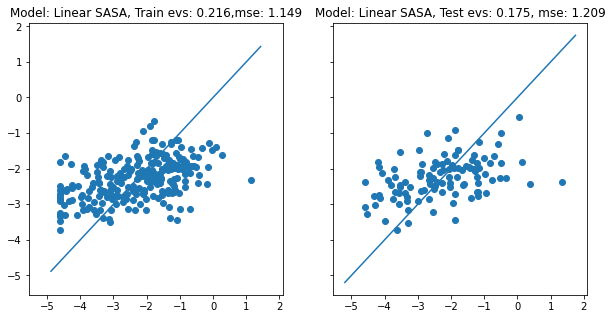

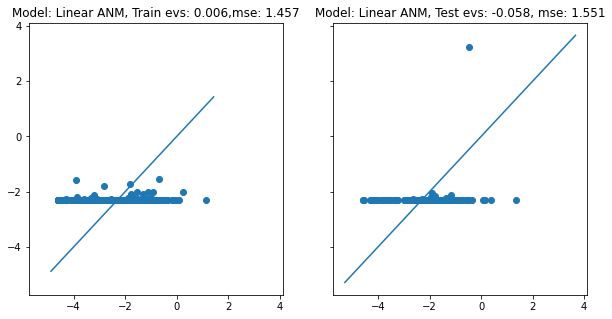

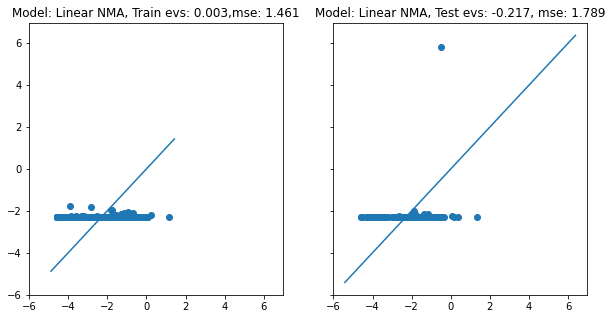

In [49]:
plot_performance(sasa_linear,linear_models['sasa'], train_target, linear_models['sasa_test'], test_target, 'Linear SASA', evs, mse)
plot_performance(anm_linear,linear_models['anm'], train_target, linear_models['anm_test'], test_target, 'Linear ANM', evs, mse)
plot_performance(nma_linear,linear_models['nma'], train_target, linear_models['nma_test'], test_target, 'Linear NMA', evs,mse)


#### random forest models


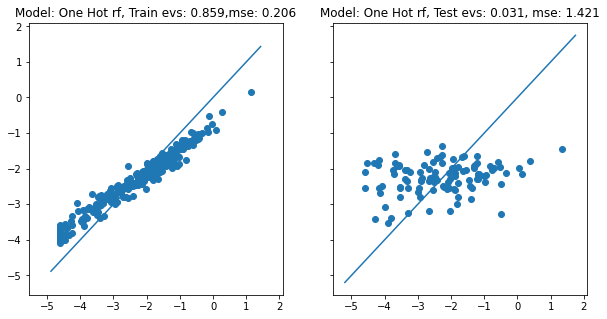

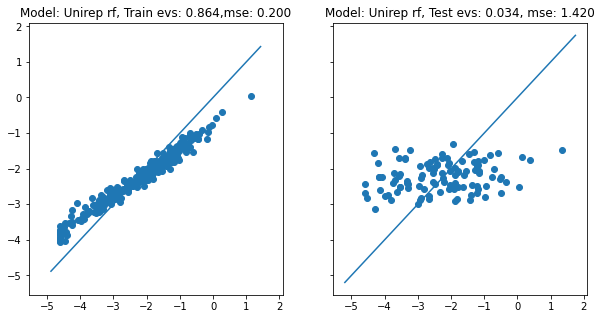

In [50]:
plot_performance(model_rfoh, train_oh, train_target, test_oh, test_target, 'One Hot rf', evs, mse)
plot_performance(model_rf_unirep, train_unirep, train_target, test_unirep, test_target, 'Unirep rf', evs,mse)